# TP2 - Fondamentaux de l'apprentissage automatique

Executed on Colab

## Pre-execution

### Verify GPU is available

In [1]:
!nvidia-smi

Thu Nov 14 04:32:00 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   44C    P8              11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

### pip installation

In [2]:
!pip install umap-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.8/88.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.9/56.9 kB 4.5 MB/s eta 0:00:00


In [3]:
!pip install \
    --extra-index-url=https://pypi.nvidia.com \
    cudf-cu12==24.10.* dask-cudf-cu12==24.10.* cuml-cu12==24.10.* \
    cugraph-cu12==24.10.* nx-cugraph-cu12==24.10.* cuspatial-cu12==24.10.* \
    cuproj-cu12==24.10.* cuxfilter-cu12==24.10.* cucim-cu12==24.10.* \
    pylibraft-cu12==24.10.* raft-dask-cu12==24.10.* cuvs-cu12==24.10.* \
    nx-cugraph-cu12==24.10.*

Looking in indexes: https://pypi.org/simple, https://pypi.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 567.7/567.7 MB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 GB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.3/4.3 MB 62.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 915.5/915.5 kB 44.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 61.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.9/196.9 MB 5.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 836.6/836.6 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 133.2/133.2 kB 12.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 73.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Imports

In [4]:
from time import time
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, classification_report
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

# Only CPU
from sklearn.ensemble import RandomForestClassifier as RFC

# GPU-accelerated
from cuml.manifold import TSNE as cumlTSNE
from cuml.manifold import UMAP as cumlUMAP



### Load datas

In [5]:
print("1. Chargement des données...")
columns = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
    "Wilderness_Area1",
    *[f"Soil_Type_{i}" for i in range(1, 40)],
    "Cover_Type"
]

print(columns)

data = pd.read_csv('https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz', header=None, names=columns)

1. Chargement des données...
['Elevation', 'Aspect', 'Slope', 'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology', 'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Wilderness_Area1', 'Soil_Type_1', 'Soil_Type_2', 'Soil_Type_3', 'Soil_Type_4', 'Soil_Type_5', 'Soil_Type_6', 'Soil_Type_7', 'Soil_Type_8', 'Soil_Type_9', 'Soil_Type_10', 'Soil_Type_11', 'Soil_Type_12', 'Soil_Type_13', 'Soil_Type_14', 'Soil_Type_15', 'Soil_Type_16', 'Soil_Type_17', 'Soil_Type_18', 'Soil_Type_19', 'Soil_Type_20', 'Soil_Type_21', 'Soil_Type_22', 'Soil_Type_23', 'Soil_Type_24', 'Soil_Type_25', 'Soil_Type_26', 'Soil_Type_27', 'Soil_Type_28', 'Soil_Type_29', 'Soil_Type_30', 'Soil_Type_31', 'Soil_Type_32', 'Soil_Type_33', 'Soil_Type_34', 'Soil_Type_35', 'Soil_Type_36', 'Soil_Type_37', 'Soil_Type_38', 'Soil_Type_39', 'Cover_Type']


### Split datas

In [6]:
X=data.drop('Cover_Type', axis=1)
y=data['Cover_Type']

# Diviser les données
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Standardize datas

In [7]:
# Standardiser les données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Fonctions

In [8]:
custom_cmap = ListedColormap(plt.cm.tab10.colors[:7])

# Fonction de visualisation
def visualize_embeddings(X, y, title):
    plt.figure(figsize=(10, 8))
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=custom_cmap, s=1)
    plt.colorbar()
    plt.title(title)
    plt.show()

In [9]:
# Function to evaluate the model
def evaluate(rfc, X_test, y_test):

    y_pred = rfc.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"Accuracy: {accuracy:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print("\nRapport de classification:")
    print(classification_report(y_test, y_pred))

In [10]:
# convert second to mm:ss

def convert(seconds):
    minutes = seconds // 60
    seconds %= 60
    return "%02d:%02d" % (minutes, seconds)

## Computing

In [11]:
smote = SMOTE(random_state=42)
X_train_scaled_over, y_train_over = smote.fit_resample(X_train_scaled, y_train)

In [12]:
rus = RandomUnderSampler(random_state=42)
X_train_scaled_under, y_train_under = rus.fit_resample(X_train_scaled, y_train)

In [13]:
# # Get reduced datasets
# print("2. Réduction de la dimensionnalité...")
# is_reduced = True

# if is_reduced:
#     n = 500

#     X_train_scaled = X_train_scaled[:n]
#     y_train = y_train[:n]
#     X_train_scaled_over = X_train_scaled_over[:n]
#     y_train_over = y_train_over[:n]
#     X_train_scaled_under = X_train_scaled_under[:n]
#     y_train_under = y_train_under[:n]


### No Sampling

In [14]:
# Compute T-SNE (GPU)

time_tsne_no_sampling = time()

tsne_no_sampling = cumlTSNE(n_components=2, random_state=42)
X_tsne_no_sampling = tsne_no_sampling.fit_transform(X_train_scaled)

time_tsne_no_sampling = time() - time_tsne_no_sampling


/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


[W] [04:39:08.134092] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


In [15]:
# Compute UMAP (GPU)

time_umap_no_sampling = time()

umap_no_sampling = cumlUMAP(n_components=2, random_state=42)
X_umap_no_sampling = umap_no_sampling.fit_transform(X_train_scaled)

time_umap_no_sampling = time() - time_umap_no_sampling

In [16]:
# Compute Random Forest Classifier (GPU)

time_rfc_no_sampling = time()

rfc_no_sampling = RFC(n_estimators=100, random_state=42)
rfc_no_sampling.fit(X_train_scaled, y_train)

time_rfc_no_sampling = time() - time_rfc_no_sampling

### Under Sampling

In [17]:
# Compute T-SNE (GPU)

time_tsne_under_sampling = time()

tsne_under_sampling = cumlTSNE(n_components=2, random_state=42)
X_tsne_under_sampling = tsne_under_sampling.fit_transform(X_train_scaled_under)

time_tsne_under_sampling = time() - time_tsne_under_sampling

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


[W] [04:42:16.690146] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


In [18]:
# Compute UMAP (GPU)

time_umap_under_sampling = time()

umap_under_sampling = cumlUMAP(n_components=2, random_state=42)
X_umap_under_sampling = umap_under_sampling.fit_transform(X_train_scaled_under)

time_umap_under_sampling = time() - time_umap_under_sampling

In [19]:
# Compute Random Forest Classifier (GPU)

time_rfc_under_sampling = time()

rfc_under_sampling = RFC(n_estimators=100, random_state=42)
rfc_under_sampling.fit(X_train_scaled_under, y_train_under)

time_rfc_under_sampling = time() - time_rfc_under_sampling

### Over Sampling

In [20]:
# Compute T-SNE (GPU)

time_tsne_over_sampling = time()

tsne_over_sampling = cumlTSNE(n_components=2, random_state=42)
X_tsne_over_sampling = tsne_over_sampling.fit_transform(X_train_scaled_over)

time_tsne_over_sampling = time() - time_tsne_over_sampling

/usr/local/lib/python3.10/dist-packages/cuml/internals/api_decorators.py:382: UserWarning: Starting from version 22.04, the default method of TSNE is 'fft'.
  return init_func(self, *args, **filtered_kwargs)


[W] [04:42:21.586944] # of Nearest Neighbors should be at least 3 * perplexity. Your results might be a bit strange...


In [21]:
# Compute UMAP (GPU)

time_umap_over_sampling = time()

umap_over_sampling = cumlUMAP(n_components=2, random_state=42)
X_umap_over_sampling = umap_over_sampling.fit_transform(X_train_scaled_over)

time_umap_over_sampling = time() - time_umap_over_sampling

In [22]:
# Compute Random Forest Classifier (GPU)

time_rfc_over_sampling = time()

rfc_over_sampling = RFC(n_estimators=100, random_state=42)
rfc_over_sampling.fit(X_train_scaled_over, y_train_over)

time_rfc_over_sampling = time() - time_rfc_over_sampling

## Results

### Speed comparison

In [23]:
print("---- No Sampling ----")
print(f"TSNE: {convert(time_tsne_no_sampling)}")
print(f"UMAP: {convert(time_umap_no_sampling)}")
print(f"RFC: {convert(time_rfc_no_sampling)}")
print("---- Under Sampling ----")
print(f"TSNE: {convert(time_tsne_under_sampling)}")
print(f"UMAP: {convert(time_umap_under_sampling)}")
print(f"RFC: {convert(time_rfc_under_sampling)}")
print("---- Over Sampling ----")
print(f"TSNE: {convert(time_tsne_over_sampling)}")
print(f"UMAP: {convert(time_umap_over_sampling)}")
print(f"RFC: {convert(time_rfc_over_sampling)}")

---- No Sampling ----
TSNE: 00:35
UMAP: 00:24
RFC: 02:09
---- Under Sampling ----
TSNE: 00:01
UMAP: 00:00
RFC: 00:02
---- Over Sampling ----
TSNE: 04:56
UMAP: 04:34
RFC: 10:52


### No Sampling

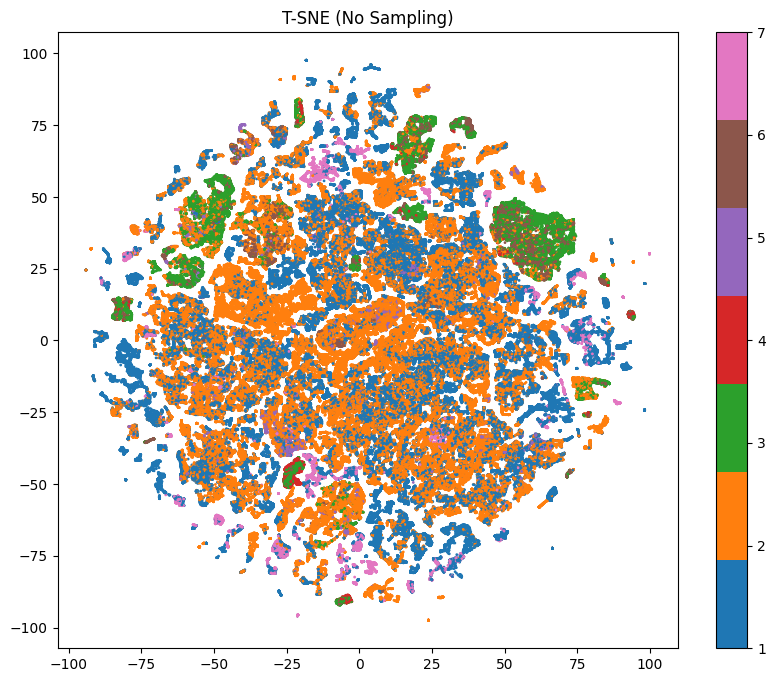

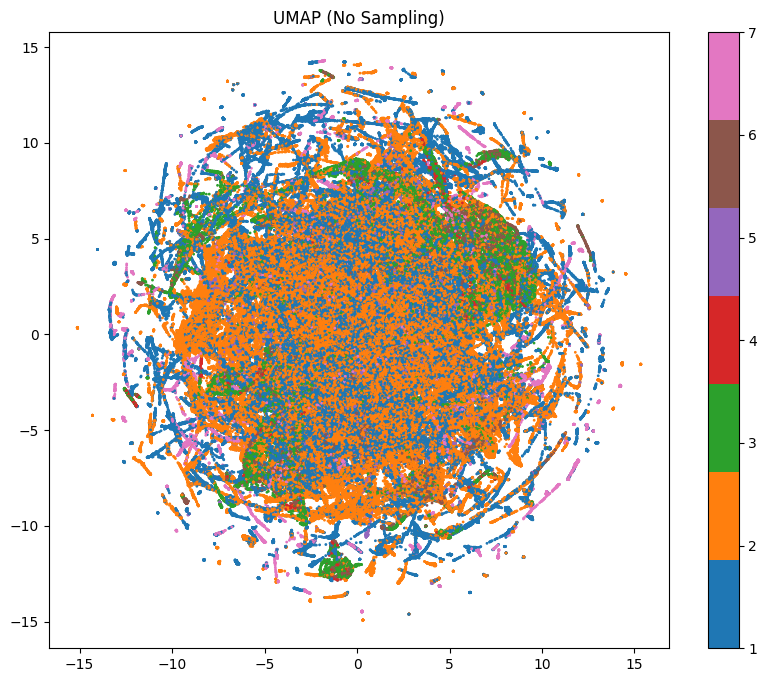

Accuracy: 0.9234
F1-Score: 0.9229

Rapport de classification:
              precision    recall  f1-score   support

           1       0.93      0.91      0.92     42557
           2       0.92      0.95      0.93     56500
           3       0.91      0.94      0.93      7121
           4       0.88      0.76      0.81       526
           5       0.92      0.69      0.79      1995
           6       0.90      0.84      0.87      3489
           7       0.96      0.93      0.95      4015

    accuracy                           0.92    116203
   macro avg       0.92      0.86      0.88    116203
weighted avg       0.92      0.92      0.92    116203



In [24]:
visualize_embeddings(X_tsne_no_sampling, y_train, "T-SNE (No Sampling)")
visualize_embeddings(X_umap_no_sampling, y_train, "UMAP (No Sampling)")
evaluate(rfc_no_sampling, X_test_scaled, y_test)

### Under Sampling

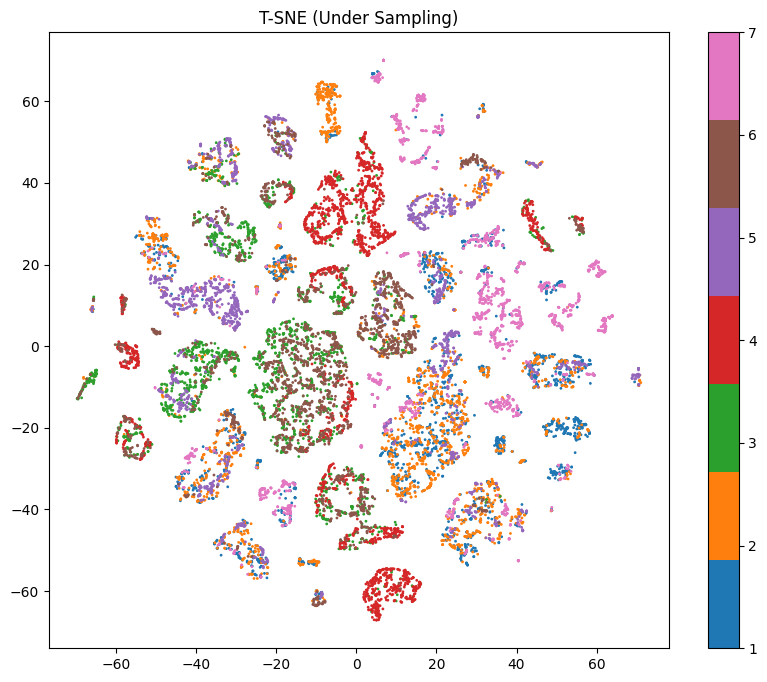

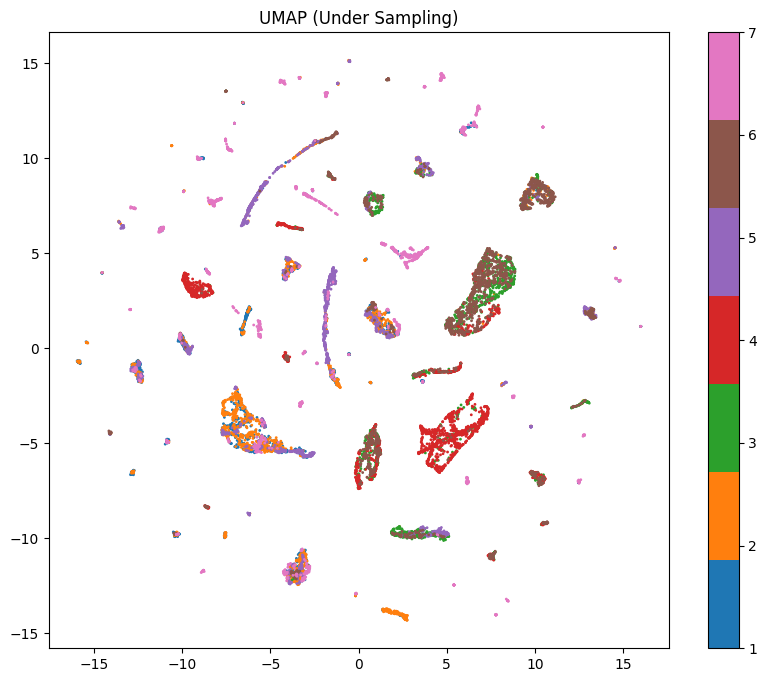

Accuracy: 0.6987
F1-Score: 0.7076

Rapport de classification:
              precision    recall  f1-score   support

           1       0.71      0.71      0.71     42557
           2       0.81      0.64      0.72     56500
           3       0.75      0.79      0.77      7121
           4       0.43      0.96      0.59       526
           5       0.25      0.93      0.39      1995
           6       0.49      0.85      0.62      3489
           7       0.56      0.95      0.70      4015

    accuracy                           0.70    116203
   macro avg       0.57      0.83      0.64    116203
weighted avg       0.74      0.70      0.71    116203



In [25]:
visualize_embeddings(X_tsne_under_sampling, y_train_under, "T-SNE (Under Sampling)")
visualize_embeddings(X_umap_under_sampling, y_train_under, "UMAP (Under Sampling)")
evaluate(rfc_under_sampling, X_test_scaled, y_test)

### Over Sampling

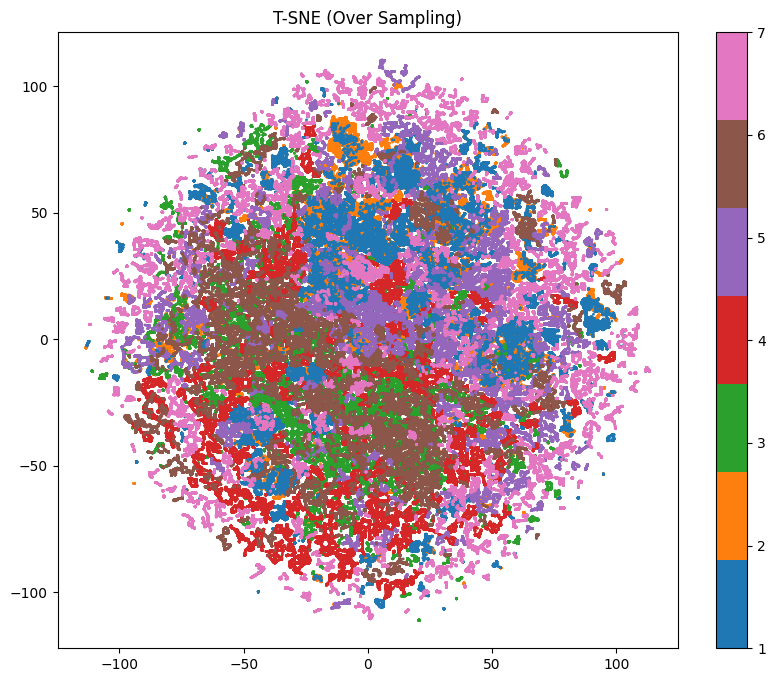

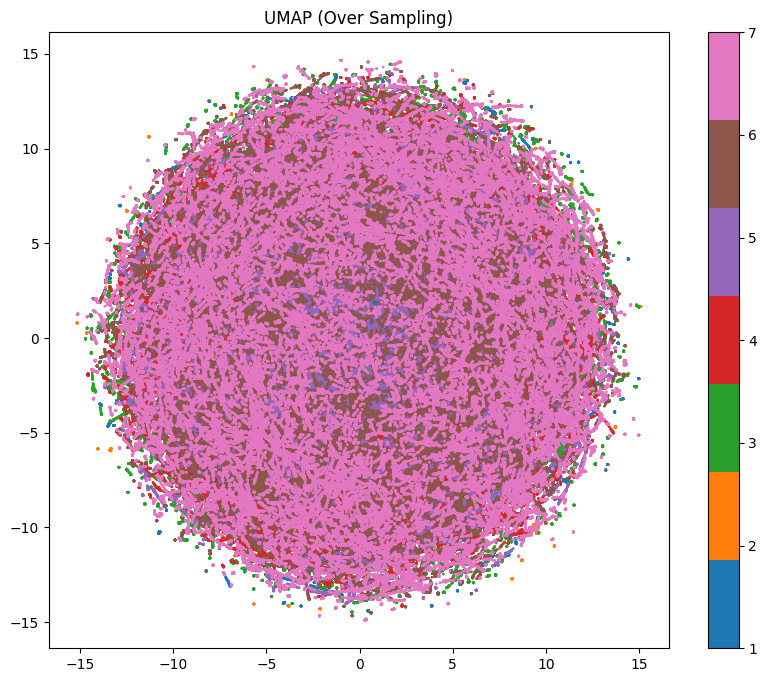

Accuracy: 0.9263
F1-Score: 0.9265

Rapport de classification:
              precision    recall  f1-score   support

           1       0.93      0.92      0.92     42557
           2       0.94      0.93      0.93     56500
           3       0.90      0.94      0.92      7121
           4       0.77      0.87      0.82       526
           5       0.79      0.87      0.83      1995
           6       0.83      0.90      0.87      3489
           7       0.93      0.97      0.95      4015

    accuracy                           0.93    116203
   macro avg       0.87      0.91      0.89    116203
weighted avg       0.93      0.93      0.93    116203



In [26]:
visualize_embeddings(X_tsne_over_sampling, y_train_over, "T-SNE (Over Sampling)")
visualize_embeddings(X_umap_over_sampling, y_train_over, "UMAP (Over Sampling)")
evaluate(rfc_over_sampling, X_test_scaled, y_test)